In [7]:
from tensorflow.keras import datasets, layers, models
import numpy as np

In [8]:
(x_train, y_train), (x_test, y_test) = datasets.fashion_mnist.load_data()

In [9]:
def preprocess(imgs):
  imgs = imgs.astype("float32") / 255.0
  imgs = np.pad(imgs, ((0,0), (2,2), (2,2)), constant_values=0.0)
  imgs = np.expand_dims(imgs, -1)
  return imgs

x_train = preprocess(x_train)
x_test = preprocess(x_test)

In [10]:
import tensorflow.keras.backend as K

encoder_input = layers.Input(shape=(32,32,1), name="encoder_input")
x = layers.Conv2D(32, (3,3), strides=2, activation='relu', padding="same")(encoder_input)
x = layers.Conv2D(64, (3,3), strides=2, activation='relu', padding='same')(x)
x = layers.Conv2D(128, (3,3), strides=2, activation='relu', padding='same')(x)
shape_before_flattening = K.int_shape(x)[1:]

x = layers.Flatten()(x)

encoder_output = layers.Dense(2, name="encoder_output")(x)
encoder = models.Model(encoder_input, encoder_output)


In [11]:
encoder.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ encoder_input (InputLayer)           │ (None, 32, 32, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 16, 16, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 8, 8, 64)            │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 4, 4, 128)           │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ encoder_output (Dense)               │ (None, 2)                   │           4,098 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 96,770 (378.01 KB)

 Trainable params: 96,770 (378.01 KB)

 Non-trainable params: 0 (0.00 B)

In [12]:
decoder_Input = layers.Input(shape=(2,), name='decoder_input')
x= layers.Dense(np.prod(shape_before_flattening))(decoder_Input)
x = layers.Reshape(shape_before_flattening)(x)
x = layers.Conv2DTranspose(
    128, (3,3), strides=2, activation='relu', padding='same'
)(x)
x = layers.Conv2DTranspose(
    64, (3,3), strides=2, activation='relu', padding='same'
)(x)
x = layers.Conv2DTranspose(
    32, (3,3), strides=2, activation='relu', padding='same'
)(x)

decoder_output = layers.Conv2D(
    1,
    (3,3),
    strides=1,
    activation="sigmoid",
    padding="same",
    name='decoder_output'
)(x)

decoder = models.Model(decoder_Input, decoder_output)

In [13]:
autoencoder = models.Model(encoder_input, decoder(encoder_output))

autoencoder.compile(optimizer="adam", loss='binary_crossentropy')

In [14]:
autoencoder.fit(x_train,
                y=x_train,
                epochs=5,
                batch_size=100,
                shuffle=True,
                validation_data=(x_test, x_test))

Epoch 1/5
600/600 ━━━━━━━━━━━━━━━━━━━━ 16s 10ms/step - loss: 0.3559 - val_loss: 0.2645
Epoch 2/5
600/600 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - loss: 0.2614 - val_loss: 0.2589
Epoch 3/5
600/600 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - loss: 0.2563 - val_loss: 0.2567
Epoch 4/5
600/600 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - loss: 0.2525 - val_loss: 0.2546
Epoch 5/5
600/600 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - loss: 0.2525 - val_loss: 0.2530


In [15]:
pred = autoencoder.predict(x_test[:2])

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


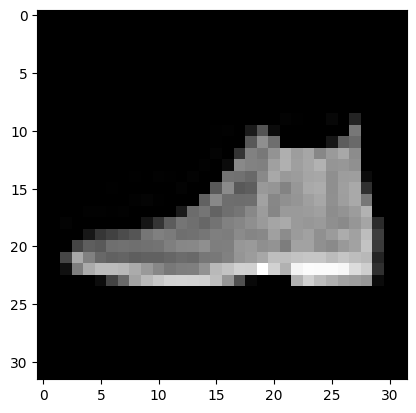

In [16]:
import matplotlib.pyplot as plt
plt.imshow(x_test[0], cmap='gray')
plt.show()

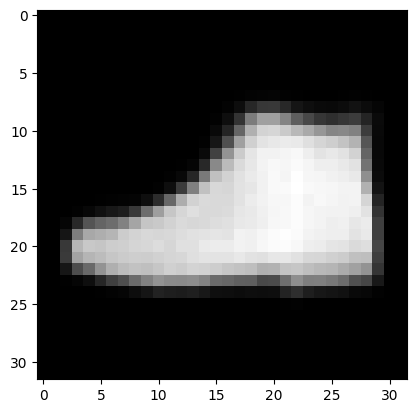

In [17]:
import matplotlib.pyplot as plt
plt.imshow(pred[0], cmap='gray')
plt.show()

157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


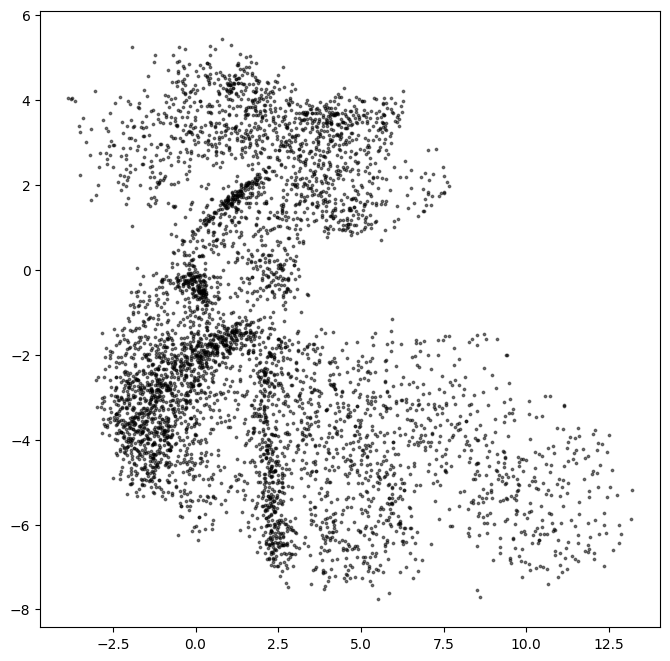

In [18]:
example_images = x_test[:5000]
embeddings = encoder.predict(example_images)

plt.figure(figsize=(8, 8))
plt.scatter(embeddings[:, 0], embeddings[:, 1], c='black', alpha=0.5, s=3)
plt.show()

In [19]:
mins, maxs = np.min(embeddings, axis=0), np.max(embeddings, axis=0)
sample = np.random.uniform(mins, maxs, size=(18, 2))
reconstructions = decoder.predict(sample)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 629ms/step


<Figure size 640x480 with 0 Axes>

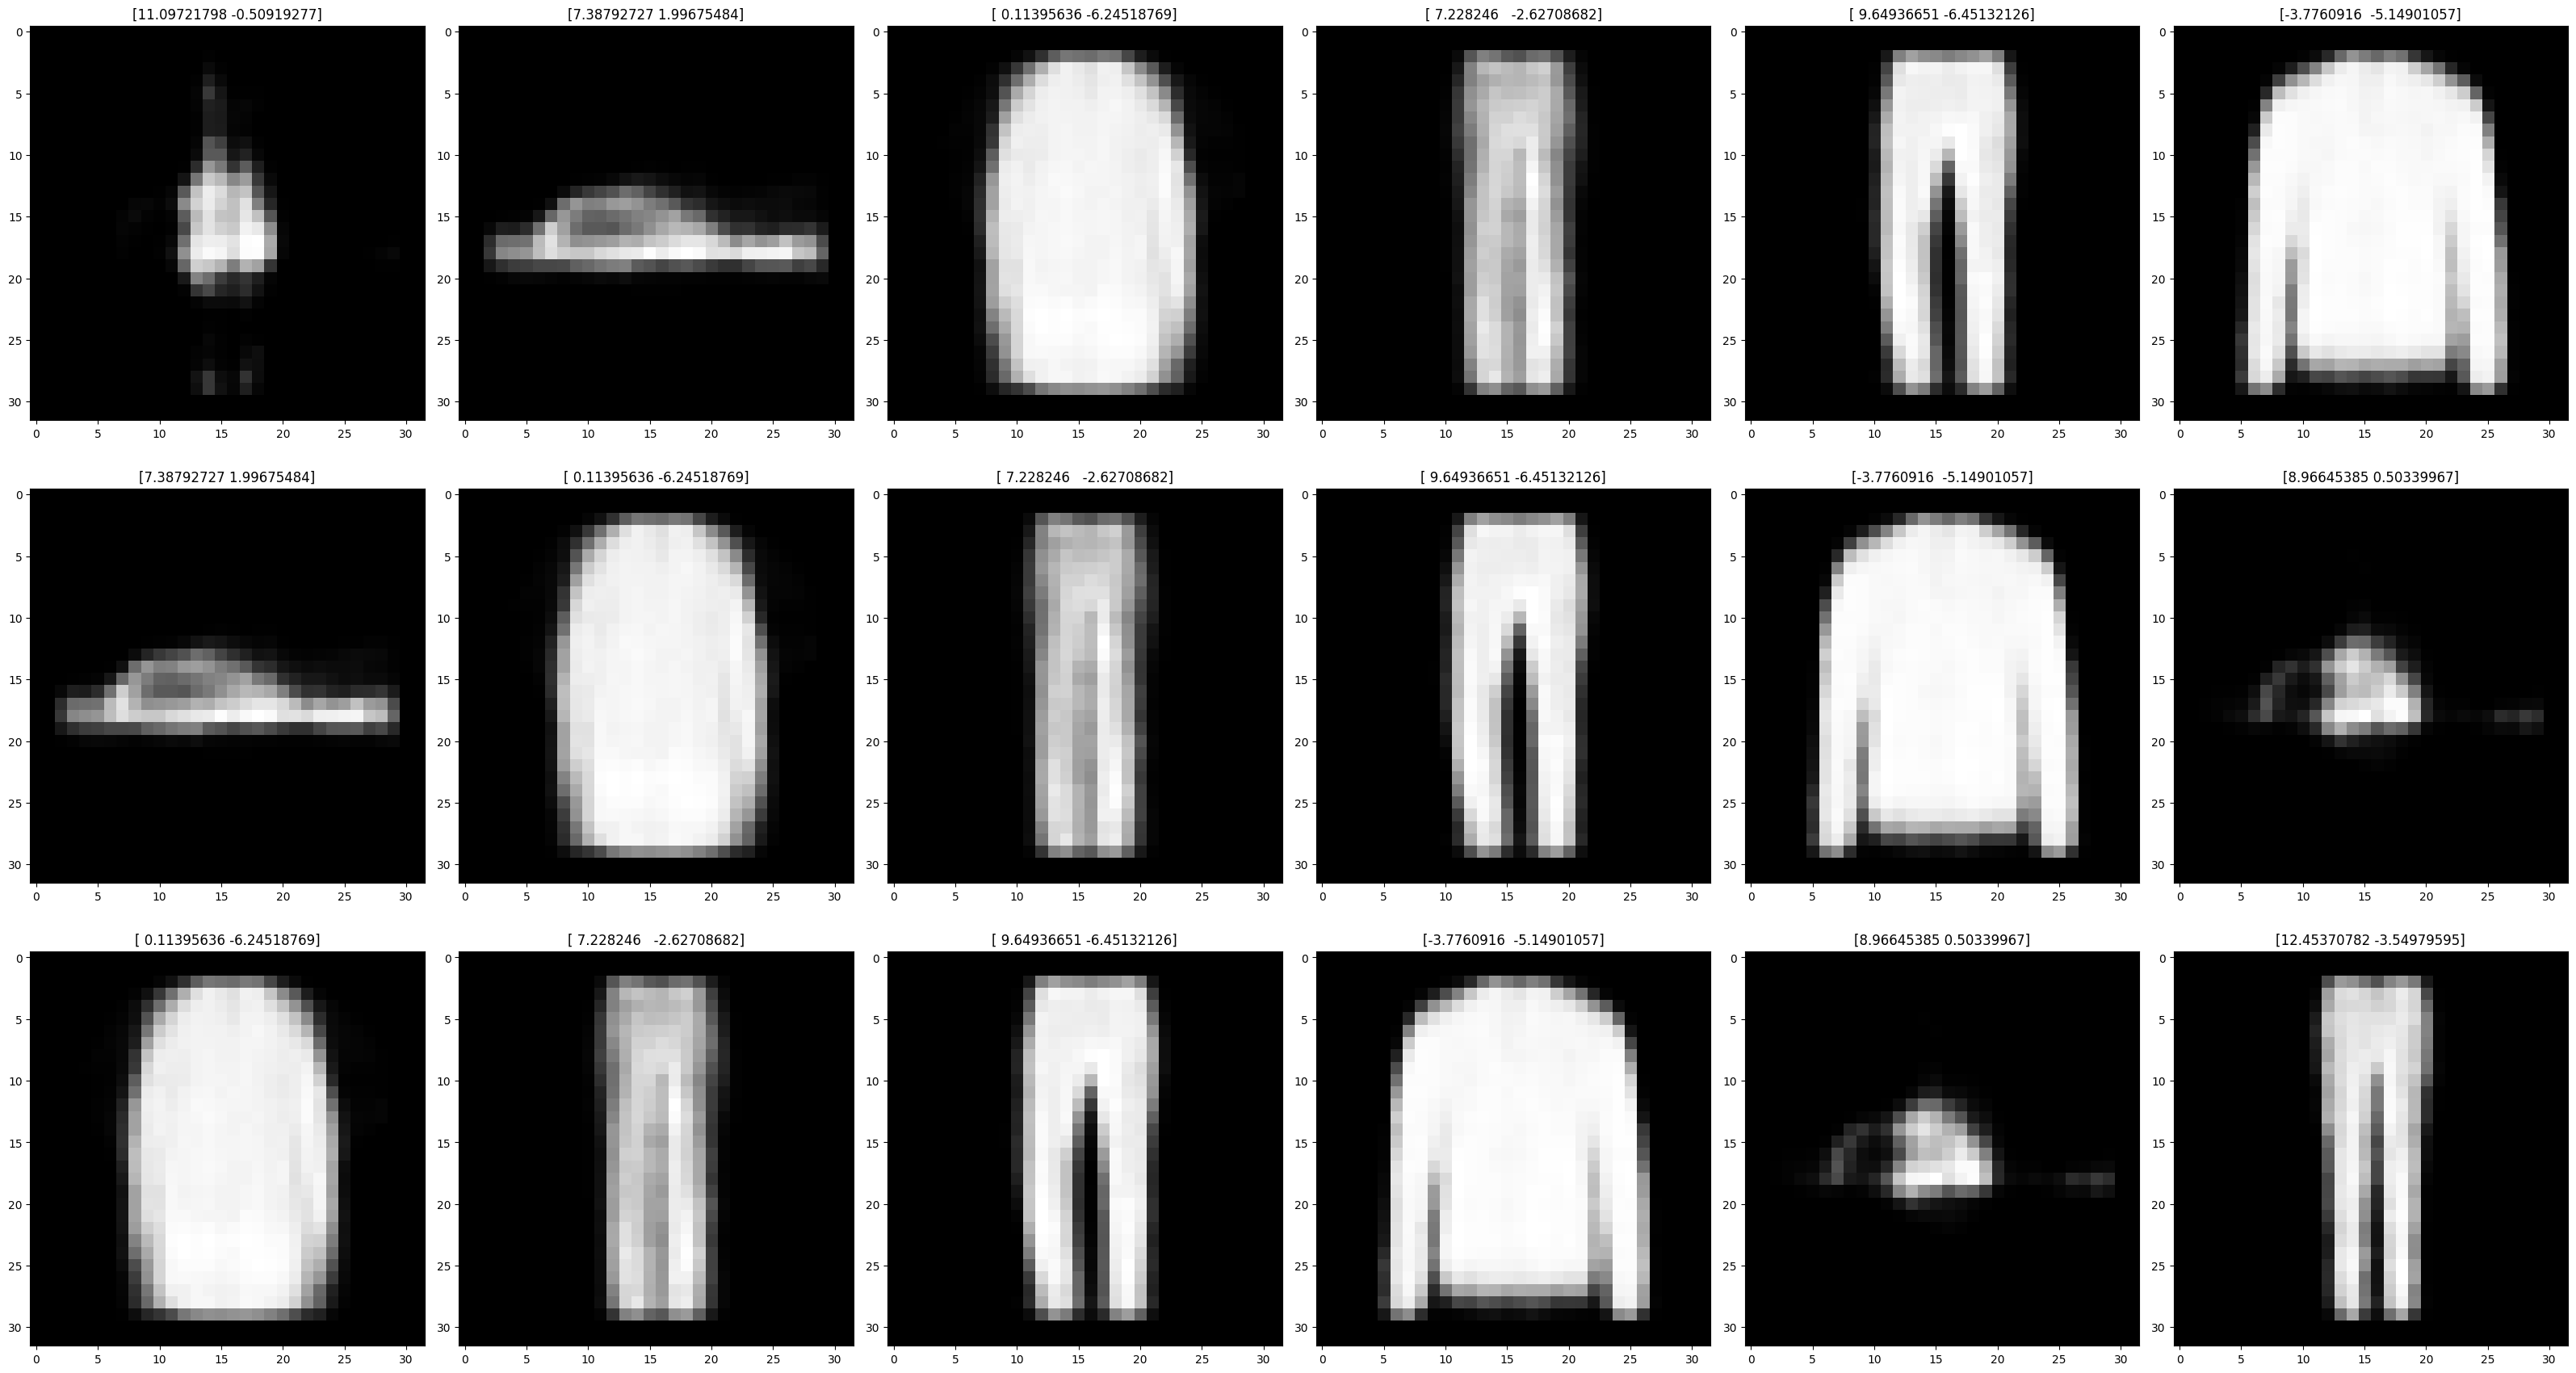

In [40]:
plt.figure()

f, ax = plt.subplots(3, 6, figsize=(32,32))
for y in range(3):
  for x in range(6):
    ax[y, x].imshow(reconstructions[y+x], cmap="gray")
    ax[y, x].set_title(f"{sample[y+x]}")
plt.tight_layout()
plt.subplots_adjust(top=0.6)
plt.show()


In [ ]:
phin